# Case 21.4 Political Persuasion

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from dmba import classificationSummary, gainsChart

DATA = Path('.').resolve().parent / 'data'

# Assignment
The task in this case is to develop an uplift model that predicts the uplift for each voter.  Uplift is defined as the increase in propensity to move one's opinion in a Democratic direction.  First, review the variables in `Voter-Persuasion.csv` and understand which data source they are probably coming from.

In [2]:
voter_df = pd.read_csv(DATA / 'Voter-Persuasion.csv')
voter_df.head()

,VOTER_ID,SET_NO,OPP_SEX,AGE,HH_ND,HH_NR,HH_NI,MED_AGE,NH_WHITE,NH_AA,...,CAND2S,MESSAGE_A,MESSAGE_A_REV,I3,CAND1_UND,CAND2_UND,MOVED_AD,MOVED_A,opposite,Partition
0,193801,2,0,28,1,1,1,37,61,34,...,S,1,0,N,N,N,N,0,1,V
1,627701,1,0,53,2,0,0,46,87,8,...,S,1,0,N,N,N,N,0,1,T
2,306924,2,0,68,2,1,0,41,23,64,...,L,1,0,N,N,N,Y,1,0,T
3,547609,1,0,66,0,2,0,35,53,29,...,S,1,0,N,N,N,N,0,1,T
4,141105,3,0,23,0,3,1,42,74,18,...,S,1,0,N,N,N,N,0,1,T


In [3]:
voter_df.columns

Index(['VOTER_ID', 'SET_NO', 'OPP_SEX', 'AGE', 'HH_ND', 'HH_NR', 'HH_NI',
       'MED_AGE', 'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'HISP',
       'COMM_LT10', 'COMM_609P', 'MED_HH_INC', 'COMM_CAR', 'COMM_CP',
       'COMM_PT', 'COMM_WALK', 'KIDS', 'M_MAR', 'F_MAR', 'ED_4COL', 'GENDER_F',
       'GENDER_M', 'H_AFDLN3P', 'H_F1', 'H_M1', 'H_MFDLN3P', 'PARTY_D',
       'PARTY_I', 'PARTY_R', 'VPP_08', 'VPP_12', 'VPR_08', 'VPR_10', 'VPR_12',
       'VG_04', 'VG_06', 'VG_08', 'VG_10', 'VG_12', 'PP_PELIG', 'PR_PELIG',
       'AP_PELIG', 'G_PELIG', 'E_PELIG', 'NL5G', 'NL3PR', 'NL5AP', 'NL2PP',
       'REG_DAYS', 'UPSCALEBUY', 'UPSCALEMAL', 'UPSCALEFEM', 'BOOKBUYERI',
       'FAMILYMAGA', 'FEMALEORIE', 'RELIGIOUSM', 'GARDENINGM', 'CULINARYIN',
       'HEALTHFITN', 'DOITYOURSE', 'FINANCIALM', 'RELIGIOUSC', 'POLITICALC',
       'MEDIANEDUC', 'CAND1S', 'CAND2S', 'MESSAGE_A', 'MESSAGE_A_REV', 'I3',
       'CAND1_UND', 'CAND2_UND', 'MOVED_AD', 'MOVED_A', 'opposite',
       'Partition'],
      dt

There are some unneeded variables that need to be removed before conducting the analysis. These are all the dependent variables (DVs) in the data: We will remove all except the DV that we are predicting from the dataset used for this example:

'CAND1S','CAND2S','I3','CAND1_UND','CAND2_UND','MOVED_AD'.

The D, R and I variables are derived from party_ and the Household Party or HHP variables are also derived from party. So these field can be dropped. Remove other unneeded variables as appropriate.

In [4]:
columns_to_drop = ['VOTER_ID', 'SET_NO', 'CAND1S','CAND2S','I3','CAND1_UND','CAND2_UND', 
                  'PARTY_D','PARTY_I','PARTY_R', 'HH_ND', 'HH_NR', 'HH_NI','VPP_12',
                  'VPP_08','PP_PELIG','NL2PP','NL5AP', 'VPR_10','NL3PR']
voter_df = voter_df.drop(columns=columns_to_drop)
voter_df.shape

(10000, 59)

`MOVED_AD` is encoded as 'Y' and 'N'. Convert to 1 and 0

In [5]:
voter_df['MOVED_AD'] = [1 if moved == 'Y' else 0 for moved in voter_df['MOVED_AD']]

# Step 1
Overall, how well did the flyer do in moving voters in a Democratic direction?  (Look at the target variable among those who got the flyer, compared to those who did not.)    

The `flyer` variable is `MESSAGE_A`

In [6]:
# crosstable 
crosstab = pd.crosstab(voter_df['MESSAGE_A'], columns=voter_df['MOVED_AD'])
crosstab

MOVED_AD,0,1
MESSAGE_A,,
0,3278,1722
1,2988,2012


In [7]:
# convert cross table to percentages by row
crosstab / crosstab.sum(axis=1) * 100

MOVED_AD,0,1
MESSAGE_A,,
0,65.56,34.44
1,59.76,40.24


Overall, the flyer is successful in moving voters in a Democratic direction.  
Of those who got the message, 40.24% moved in a favorable direction.  
Of those who did not, only 34.44% moved. 

# Step 2
Explore the data to learn more about the relationships between the predictor variables and `MOVED_AD` (visualization can be helpful). Which of the predictors seem to have good predictive potential? Show supporting charts and/or tables.

In [8]:
predictors = voter_df.columns
predictors

Index(['OPP_SEX', 'AGE', 'MED_AGE', 'NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT',
       'HISP', 'COMM_LT10', 'COMM_609P', 'MED_HH_INC', 'COMM_CAR', 'COMM_CP',
       'COMM_PT', 'COMM_WALK', 'KIDS', 'M_MAR', 'F_MAR', 'ED_4COL', 'GENDER_F',
       'GENDER_M', 'H_AFDLN3P', 'H_F1', 'H_M1', 'H_MFDLN3P', 'VPR_08',
       'VPR_12', 'VG_04', 'VG_06', 'VG_08', 'VG_10', 'VG_12', 'PR_PELIG',
       'AP_PELIG', 'G_PELIG', 'E_PELIG', 'NL5G', 'REG_DAYS', 'UPSCALEBUY',
       'UPSCALEMAL', 'UPSCALEFEM', 'BOOKBUYERI', 'FAMILYMAGA', 'FEMALEORIE',
       'RELIGIOUSM', 'GARDENINGM', 'CULINARYIN', 'HEALTHFITN', 'DOITYOURSE',
       'FINANCIALM', 'RELIGIOUSC', 'POLITICALC', 'MEDIANEDUC', 'MESSAGE_A',
       'MESSAGE_A_REV', 'MOVED_AD', 'MOVED_A', 'opposite', 'Partition'],
      dtype='object')

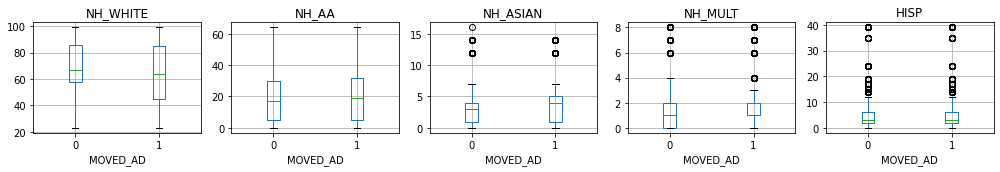

In [9]:
def boxplots(columns, ncols=5):
    nrows = 1 + (len(columns) - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 2.5))
    for i, column in enumerate(columns):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        voter_df.boxplot(column=column, by='MOVED_AD', ax=ax)
    for i in range(len(columns), nrows * ncols):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        fig.delaxes(ax)
    fig.suptitle('')
    plt.tight_layout()

ethnicity_variables = ['NH_WHITE', 'NH_AA', 'NH_ASIAN', 'NH_MULT', 'HISP']
boxplots(ethnicity_variables, ncols=5)

Boxplot reveals some association between 

- % Non-Hispanic Caucasian (NH_WHITE) and Movement in Democratic Direction.
- % Non-Hispanic Asian (NH_ASIAN) and Movement in Democratic Direction (MOVED_AD).
- % Non-Hispanic multi-race (NH_MULT) and Movement in Democratic Direction (MOVED_AD).

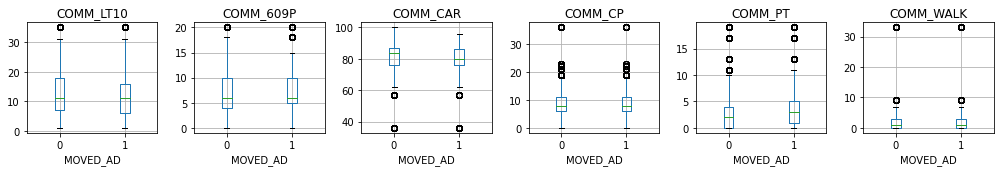

In [10]:
commuting_variables = ['COMM_LT10', 'COMM_609P', 'COMM_CAR', 'COMM_CP', 'COMM_PT', 'COMM_WALK']
boxplots(commuting_variables, ncols=6)

Boxplot reveals some association between
- % of workers who commute 60+ minutes each way(COMM_609P) and Movement in Democratic Direction (MOVED_AD)
- % of workers who commute by car (COMM_CAR) and Movement in Democratic Direction (MOVED_AD)
- % of workers who commute by public transport (COMM_PT) and Movement in Democratic Direction (MOVED_AD)

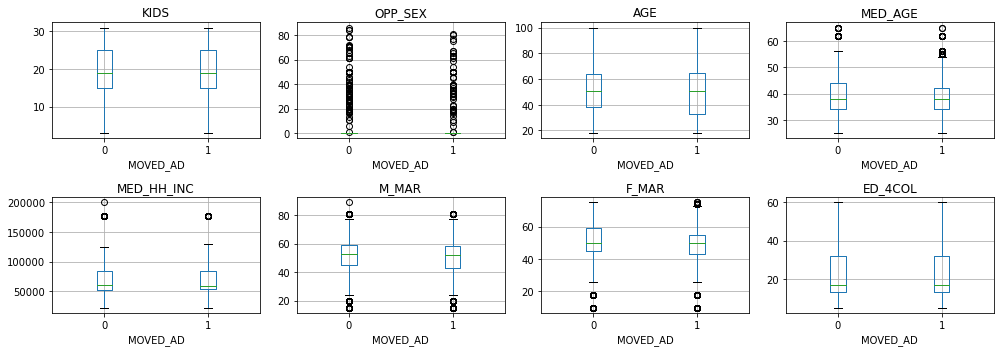

In [11]:
household_variables = ['KIDS', 'OPP_SEX', 'AGE', 'MED_AGE', 'MED_HH_INC', 'M_MAR', 'F_MAR', 'ED_4COL']
boxplots(household_variables, ncols=4)

Boxplot reveals little association 
- % of adult men who are married and living with spouse (F_MAR) and Movement in Democratic Direction (MOVED_AD)

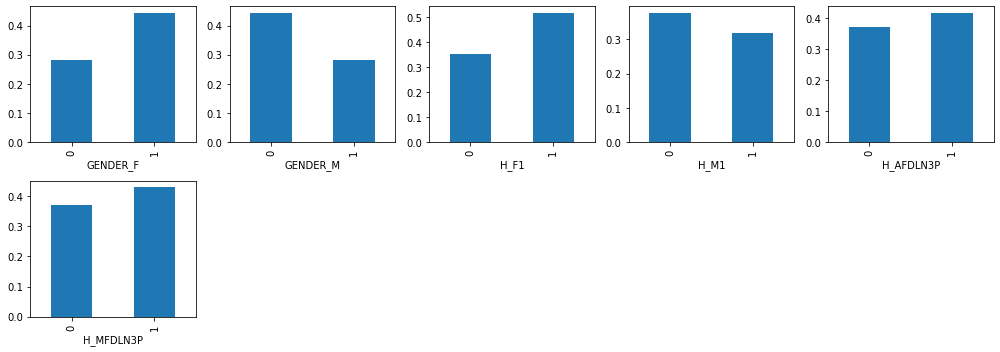

In [12]:
def barcharts(columns, ncols=5):
    nrows = 1 + (len(columns) - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 2.5))
    for i, column in enumerate(columns):
        uniqueValues = sorted(voter_df[column].unique())
        freq = pd.DataFrame({
            column: uniqueValues,
            '% of MOVED_AD': [voter_df[voter_df[column] == value]['MOVED_AD'].mean() for value in uniqueValues],
        })
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freq['% of MOVED_AD'].plot(kind='bar', ax=ax, legend=False)
        ax.set_xlabel(column)
    for i in range(len(columns), nrows * 5):
        ax = axes[i // 5, i % 5] if nrows > 1 else axes[i]
        fig.delaxes(ax)
    plt.tight_layout()

genderInformation = ['GENDER_F', 'GENDER_M', 'H_F1', 'H_M1', 'H_AFDLN3P', 'H_MFDLN3P']
barcharts(genderInformation, ncols=5)

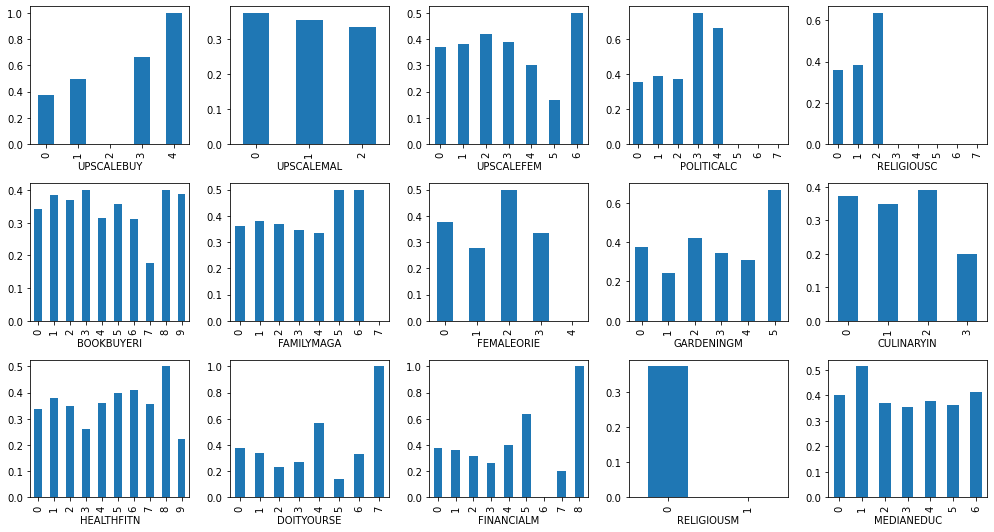

In [13]:
interestVariables = ['UPSCALEBUY', 'UPSCALEMAL', 'UPSCALEFEM', 
                     'POLITICALC', 'RELIGIOUSC',
                     'BOOKBUYERI', 'FAMILYMAGA', 'FEMALEORIE', 'GARDENINGM', 'CULINARYIN', 'HEALTHFITN', 
                     'DOITYOURSE', 'FINANCIALM', 'RELIGIOUSM', 'MEDIANEDUC']
barcharts(interestVariables, ncols=5)

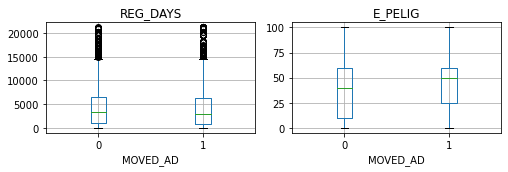

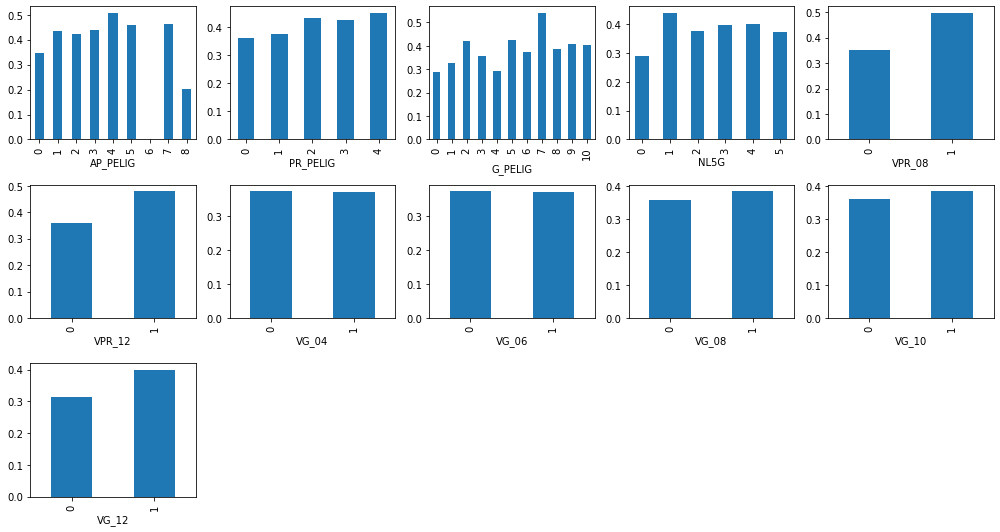

In [14]:
voting_history1 = ['REG_DAYS', 'E_PELIG']
boxplots(voting_history1, ncols=4)
voting_history2 = ['AP_PELIG', 'PR_PELIG', 'G_PELIG', 'NL5G', 'VPR_08', 'VPR_12', 'VG_04', 'VG_06', 'VG_08', 'VG_10', 'VG_12']
barcharts(voting_history2, ncols=5)

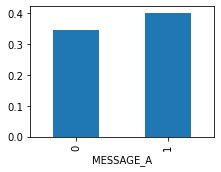

In [15]:
campaign_variables = ['MESSAGE_A']
barcharts(campaign_variables, ncols=5)

In [16]:
columns = set(voter_df.columns)
columns.difference_update(ethnicity_variables)
columns.difference_update(commuting_variables)
columns.difference_update(household_variables)
columns.difference_update(genderInformation)
columns.difference_update(interestVariables)
columns.difference_update(voting_history1)
columns.difference_update(voting_history2)
columns.difference_update(campaign_variables)

print('Remaining columns', columns)

Remaining columns {'opposite', 'Partition', 'MOVED_AD', 'MOVED_A', 'MESSAGE_A_REV'}


# Step 3
Partition the data using the partition variable that is in the dataset, make decisions about predictor inclusion, and fit three predictive models accordingly. For each model, give sufficient detail about the method used, its parameters, and the predictors used, so that your results can be replicated.

In [17]:
train_df = voter_df[voter_df['Partition'] == 'T']
valid_df = voter_df[voter_df['Partition'] == 'V']
train_df.shape, valid_df.shape

((5948, 59), (4052, 59))

In [18]:
outcome = 'MOVED_AD'
predictors = (ethnicity_variables + commuting_variables + household_variables + 
              genderInformation + interestVariables + voting_history1 + voting_history1 +
              campaign_variables)

train_X = train_df[predictors]
train_y = train_df[outcome]

valid_X = valid_df[predictors]
valid_y = valid_df[outcome]

In [19]:
# Helper functions
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

## Logistic regression

In [20]:
logit_reg = LogisticRegressionCV(penalty="l2", solver='saga', cv=5, max_iter=8000)
logit_reg.fit(train_X, train_y)
logit_reg_confusion = confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.6221)

       Prediction
Actual    0    1
     0 3694    1
     1 2247    6
Logistic regression - validation results
Confusion Matrix (Accuracy 0.6347)

       Prediction
Actual    0    1
     0 2570    1
     1 1479    2


## Decision tree classifier

In [21]:
dtree = DecisionTreeClassifier()
dtree.fit(train_X, train_y)
dtree_confusion = confusionMatrices(dtree, 'Decision tree')

Decision tree - training results
Confusion Matrix (Accuracy 0.9993)

       Prediction
Actual    0    1
     0 3695    0
     1    4 2249
Decision tree - validation results
Confusion Matrix (Accuracy 0.6024)

       Prediction
Actual    0    1
     0 1699  872
     1  739  742


## Random forest classifier

In [22]:
rfModel = RandomForestClassifier(n_estimators=100)
rfModel.fit(train_X, train_y)
confusionMatrices(rfModel, 'Random forest')

Random forest - training results
Confusion Matrix (Accuracy 0.9993)

       Prediction
Actual    0    1
     0 3693    2
     1    2 2251
Random forest - validation results
Confusion Matrix (Accuracy 0.6540)

       Prediction
Actual    0    1
     0 2035  536
     1  866  615


# Step 4
Among your three models, choose the best one in terms of predictive power. Which one is it? Why did you choose it?

The random forest classifier has the highest accuracy on the validation set.

# Step 5
Using your chosen model, report the propensities for the first three records in the validation set.

In [23]:
print(rfModel.predict(valid_X.iloc[:3,]))
print(rfModel.predict_proba(valid_X.iloc[:3,]))
print(valid_y[:3])

print('propensities of first three records:', rfModel.predict_proba(valid_X.iloc[:3,])[:,1])

[0 0 0]
[[0.55 0.45]
 [0.66 0.34]
 [0.65 0.35]]
0    0
8    1
9    0
Name: MOVED_AD, dtype: int64
propensities of first three records: [0.45 0.34 0.35]


# Step 6
Create a derived variable that is the opposite of _Flyer_. Call it _Flyer-reversed_. Using your chosen model, re-score the validation data using the  _Flyer-reversed_ variable as a predictor, instead of _Flyer_. 
Report the propensities for the first three records in the validation set.

In [24]:
# make a copy of valid_X and reverse MESSAGE_A
valid_X
valid_X_reversed = valid_X.copy()
valid_X_reversed['MESSAGE_A'] = 1 - valid_X_reversed['MESSAGE_A']

print(rfModel.predict(valid_X_reversed.iloc[:3,]))
print(rfModel.predict_proba(valid_X_reversed.iloc[:3,]))
print(valid_y[:3])

print('Propensities of first three records:', rfModel.predict_proba(valid_X_reversed.iloc[:3,])[:,1])

[0 0 0]
[[0.5  0.5 ]
 [0.68 0.32]
 [0.68 0.32]]
0    0
8    1
9    0
Name: MOVED_AD, dtype: int64
Propensities of first three records: [0.5  0.32 0.32]


# Step 7
For each record, uplift is computed based on the following difference: 

$$
P(success | Flyer = 1) - P(success | Flyer = 0)
$$ 

Compute the uplift for each of the voters in the validation set, and report the uplift for the first three records. 

In [25]:
uplift_df = valid_X.copy()
uplift_df['MESSAGE_A'] = 1
predTreatment = rfModel.predict_proba(uplift_df)

uplift_df['MESSAGE_A'] = 0
predControl = rfModel.predict_proba(uplift_df)

upliftResult_df = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
    }, index=uplift_df.index)
upliftResult_df.head()

,probMessage,probNoMessage,uplift
0,0.45,0.50,-0.05
8,0.34,0.32,0.02
9,0.35,0.32,0.03
10,0.68,0.77,-0.09
12,0.32,0.29,0.03


# Step 8
If a campaign has the resources to mail the flyer only to 10\% of the voters, what uplift cutoff should be used?



In [26]:
nrecords = len(upliftResult_df)
print('Number of records ', nrecords)
upliftResult_df = upliftResult_df.sort_values(by=['uplift'], ascending=False)
upliftResult_df['ranking'] = range(1, nrecords + 1)
upliftResult_df.head()

Number of records  4052


,probMessage,probNoMessage,uplift,ranking
8967,0.65,0.12,0.53,1
1371,0.73,0.25,0.48,2
4454,0.73,0.26,0.47,3
4757,0.67,0.21,0.46,4
1175,0.51,0.05,0.46,5


Cutoff to target 10%: 0.19


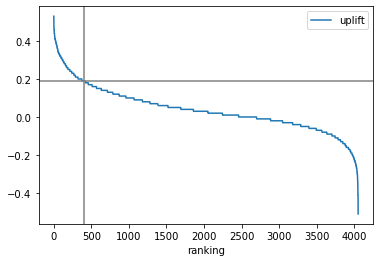

In [27]:
cutoff = upliftResult_df.iloc[int(0.1*nrecords), 2]
print(f'Cutoff to target 10%: {cutoff:.2f}')
ax = upliftResult_df.plot(x='ranking', y='uplift')
ax.axvline(x=0.1 * len(upliftResult_df) + 1, color='grey')
ax.axhline(y=cutoff, color='grey')
plt.show()